In [ ]:
import warnings
warnings.filterwarnings("ignore")
import math
from itertools import combinations, product

# Data Handling
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical Modeling
import statsmodels.api as sm
from scipy.stats import pointbiserialr, f_oneway, chi2_contingency
from scipy.stats import boxcox

# ML Models
from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso,Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Complex ML Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# ML Utilities
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
df = pd.read_csv("data/insurance.csv")
df = df.drop('index', axis=1)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=['number']).columns.tolist()

print("Categorical Features:")
print(categorical_features)

print("\nDistinct values for each categorical feature:")
for feature in categorical_features:
    distinct_values = df[feature].nunique()
    unique_values = df[feature].unique()
    print(f"{feature}: {distinct_values} unique values")
    print(f"Values: {unique_values}")

print("\nNumerical Features:")
print(numerical_features)

Categorical Features:
['sex', 'smoker', 'region']

Distinct values for each categorical feature:
sex: 2 unique values
Values: ['female' 'male']
smoker: 2 unique values
Values: ['yes' 'no']
region: 4 unique values
Values: ['southwest' 'southeast' 'northwest' 'northeast']

Numerical Features:
['age', 'bmi', 'children', 'charges']


In [ ]:
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)
empty_string_counts = (df[categorical_features] == '').sum()
print("\nEmpty Counts in Categorical Features:")
print(empty_string_counts)

Missing Values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Empty Counts in Categorical Features:
sex       0
smoker    0
region    0
dtype: int64


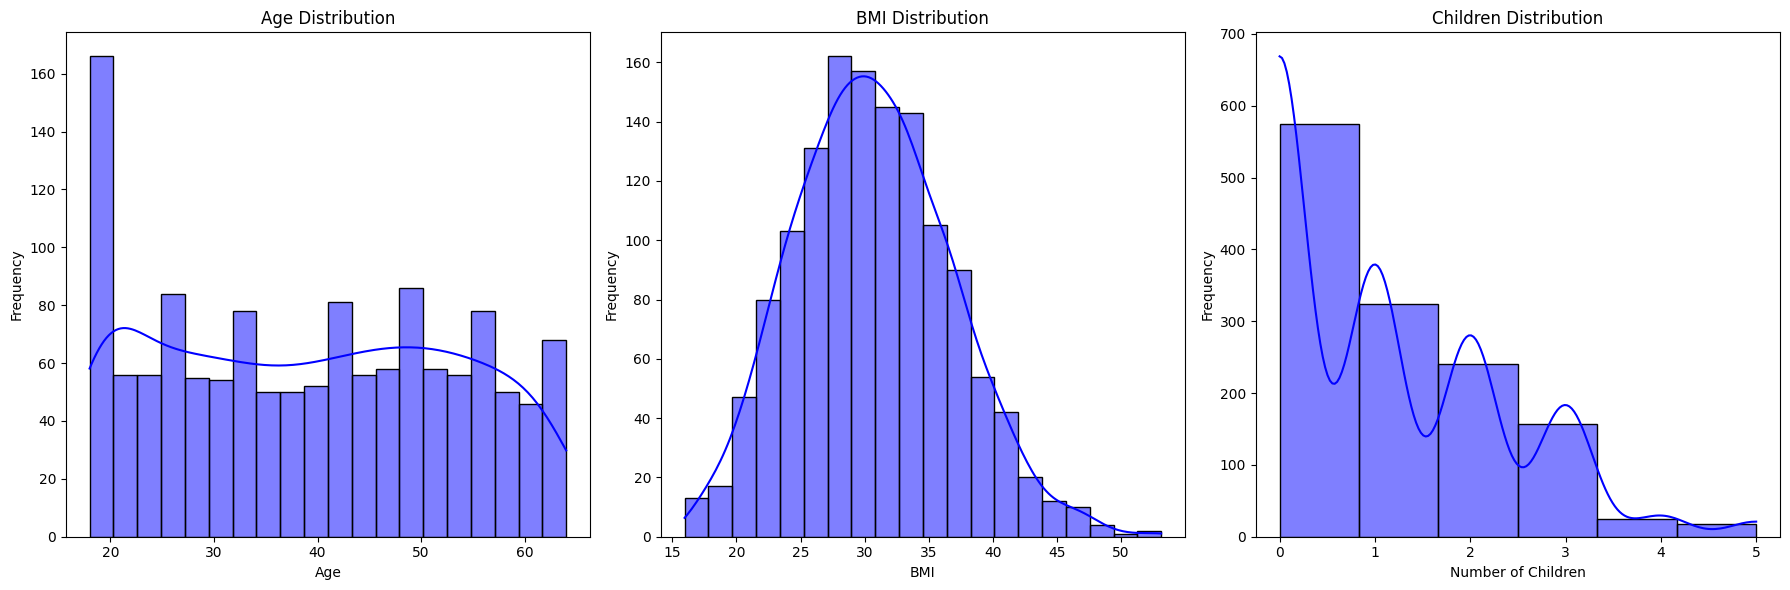

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(df['age'], bins=20, kde=True, color='blue', alpha=0.5, ax=axs[0])
axs[0].set_title('Age Distribution')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')

sns.histplot(df['bmi'], bins=20, kde=True, color='blue', alpha=0.5, ax=axs[1])
axs[1].set_title('BMI Distribution')
axs[1].set_xlabel('BMI')
axs[1].set_ylabel('Frequency')

sns.histplot(df['children'], bins=6, kde=True, color='blue', alpha=0.5, ax=axs[2])
axs[2].set_title('Children Distribution')
axs[2].set_xlabel('Number of Children')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

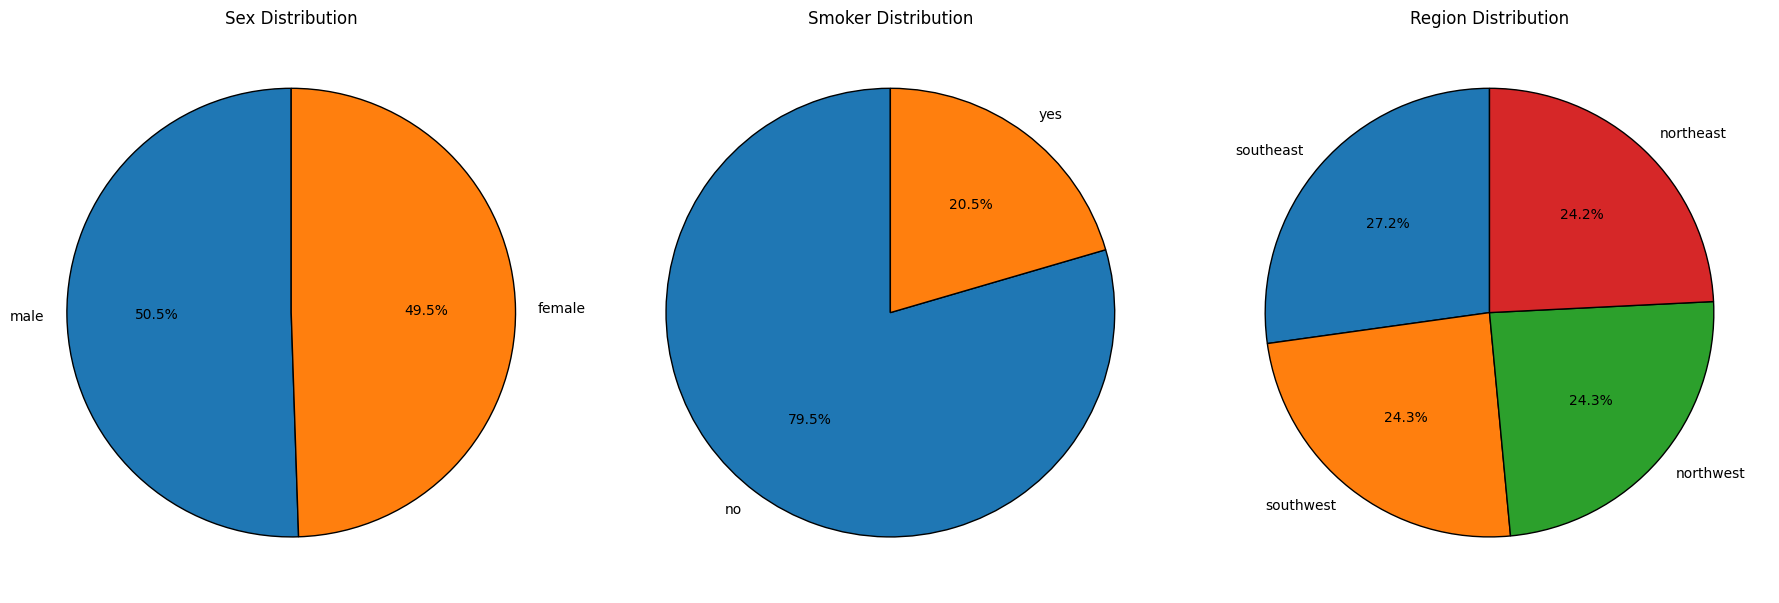

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Pie chart for 'sex' distribution
sex_counts = df['sex'].value_counts()
axs[0].pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
axs[0].set_title('Sex Distribution')

# Pie chart for 'smoker' distribution
smoker_counts = df['smoker'].value_counts()
axs[1].pie(smoker_counts, labels=smoker_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
axs[1].set_title('Smoker Distribution')

# Pie chart for 'region' distribution
region_counts = df['region'].value_counts()
axs[2].pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
axs[2].set_title('Region Distribution')

# Adjust layout
plt.tight_layout()
plt.show()

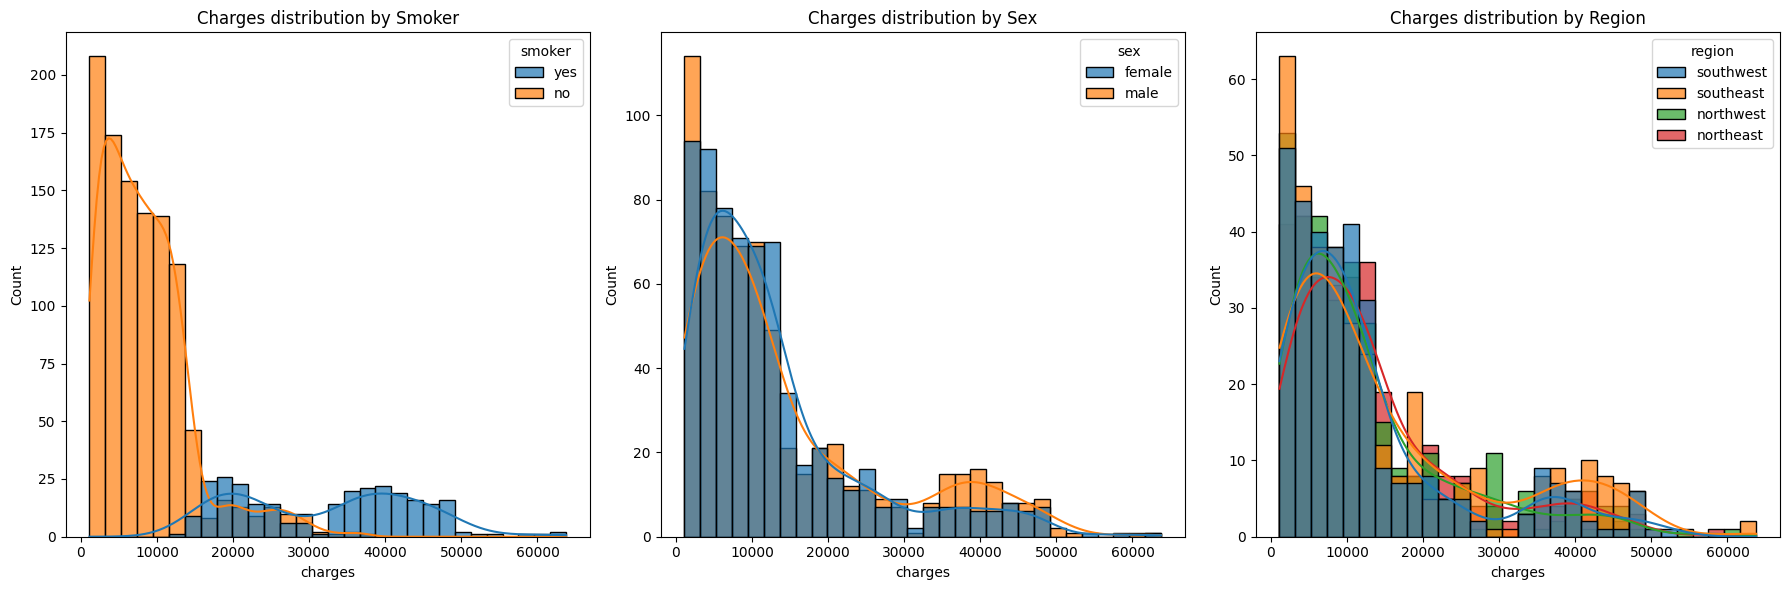

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(df, x='charges', hue='smoker', kde=True, alpha=0.7, linewidth=1, ax=axs[0])
axs[0].set_title('Charges distribution by Smoker')
sns.histplot(df, x='charges', hue='sex', kde=True, alpha=0.7, linewidth=1, ax=axs[1])
axs[1].set_title('Charges distribution by Sex')
sns.histplot(df, x='charges', hue='region', kde=True, alpha=0.7, linewidth=1, ax=axs[2])
axs[2].set_title('Charges distribution by Region')
plt.tight_layout()
plt.show()

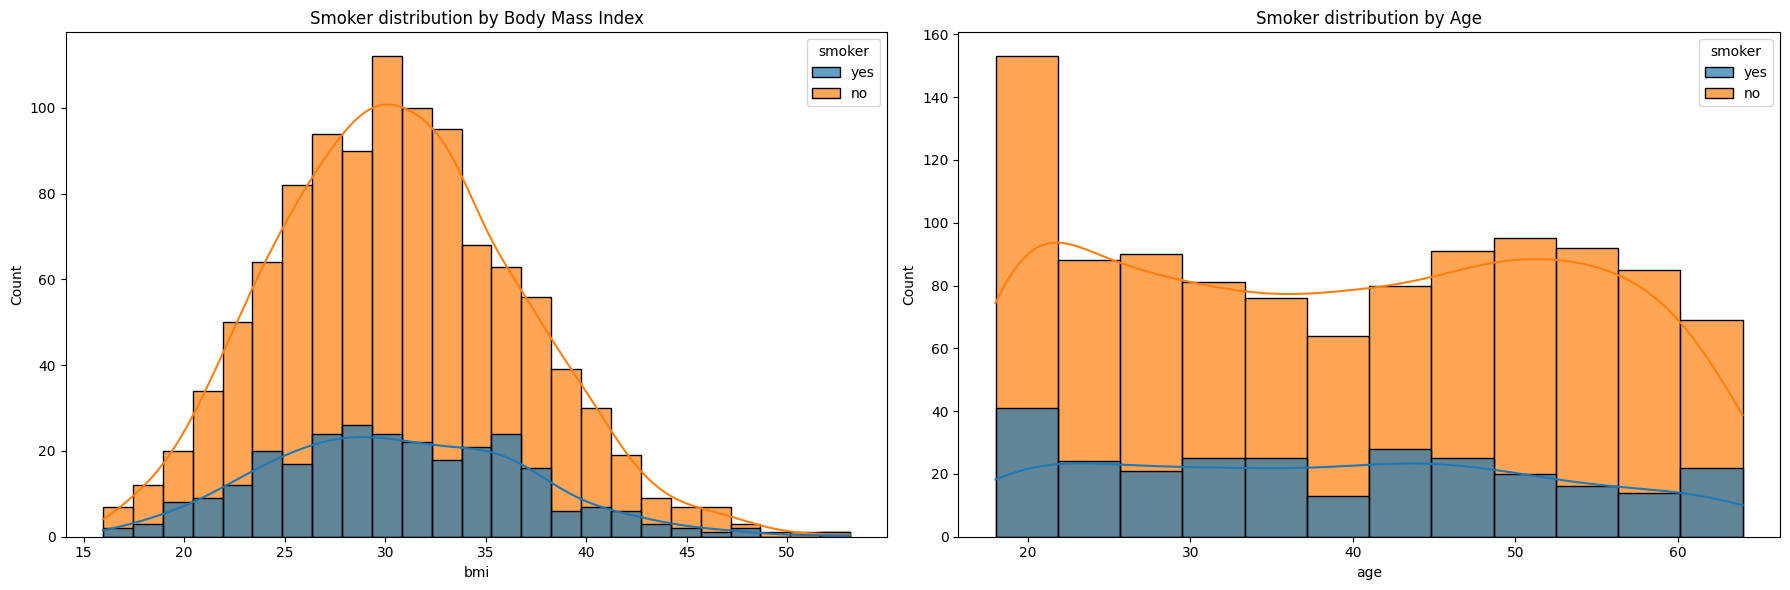

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(df, x='bmi', hue='smoker', kde=True, alpha=0.7, linewidth=1, ax=axs[0])
axs[0].set_title('Smoker distribution by Body Mass Index')
sns.histplot(df, x='age', hue='smoker', kde=True, alpha=0.7, linewidth=1, ax=axs[1])
axs[1].set_title('Smoker distribution by Age')
plt.tight_layout()
plt.show()

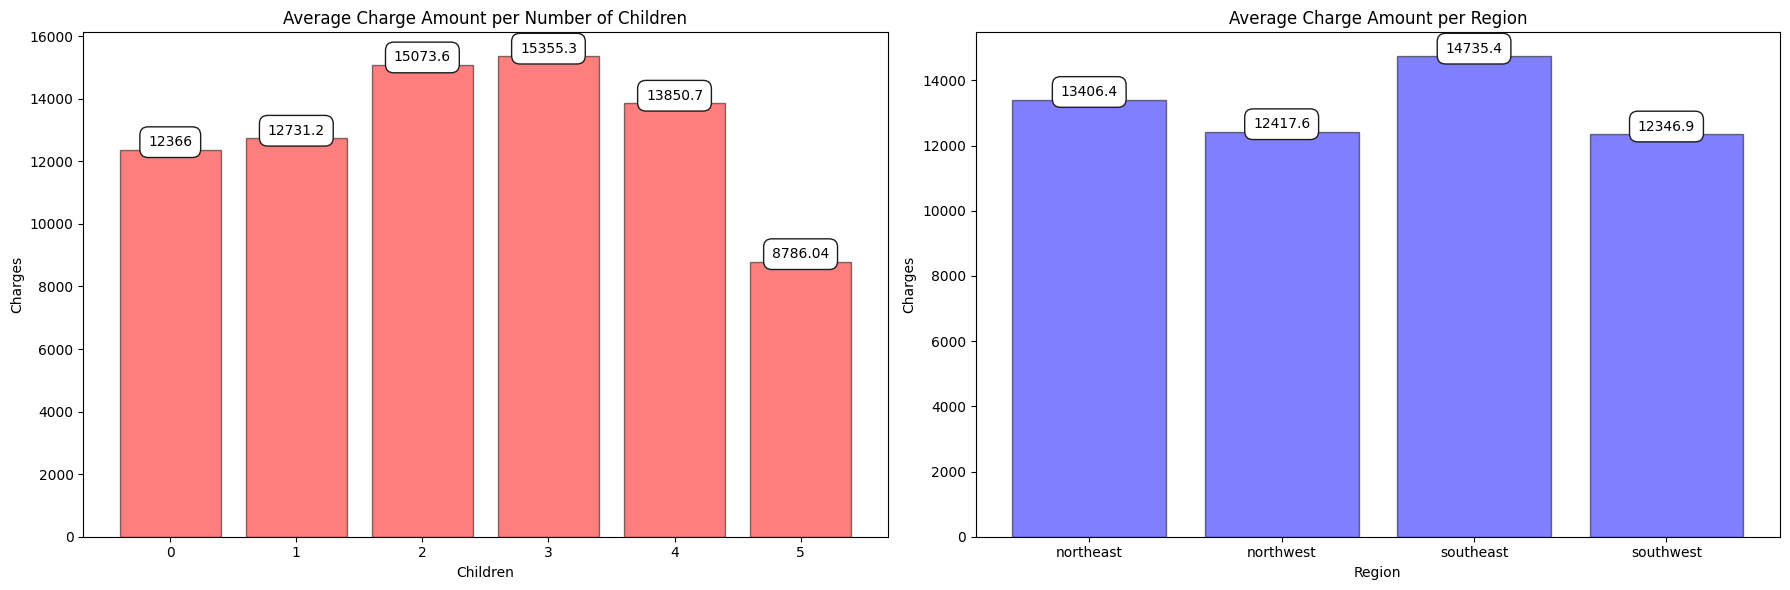

In [ ]:
child = df.pivot_table(index='children', values='charges').sort_index().reset_index()
region = df.pivot_table(index='region', values='charges').sort_index().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].bar(child['children'], child['charges'], color='red', alpha=0.5, edgecolor='black')
axs[0].set_title('Average Charge Amount per Number of Children')
axs[0].set_xlabel('Children')
axs[0].set_ylabel('Charges')
for container in axs[0].containers:
    axs[0].bar_label(container, label_type='edge', padding=0.5,
                     bbox={"boxstyle": "round", "pad": 0.6, "facecolor": "white", "edgecolor": "#1c1c1c", "alpha": 1})

axs[1].bar(region['region'], region['charges'], color='blue', alpha=0.5, edgecolor='black')
axs[1].set_title('Average Charge Amount per Region')
axs[1].set_xlabel('Region')
axs[1].set_ylabel('Charges')
for container in axs[1].containers:
    axs[1].bar_label(container, label_type='edge', padding=0.5,
                     bbox={"boxstyle": "round", "pad": 0.6, "facecolor": "white","edgecolor": "#1c1c1c", "alpha": 1})

plt.tight_layout()
plt.show()

Skewness values:
 age         0.055673
bmi         0.284047
children    0.938380
charges     1.515880
dtype: float64

children (skewness: 0.94)


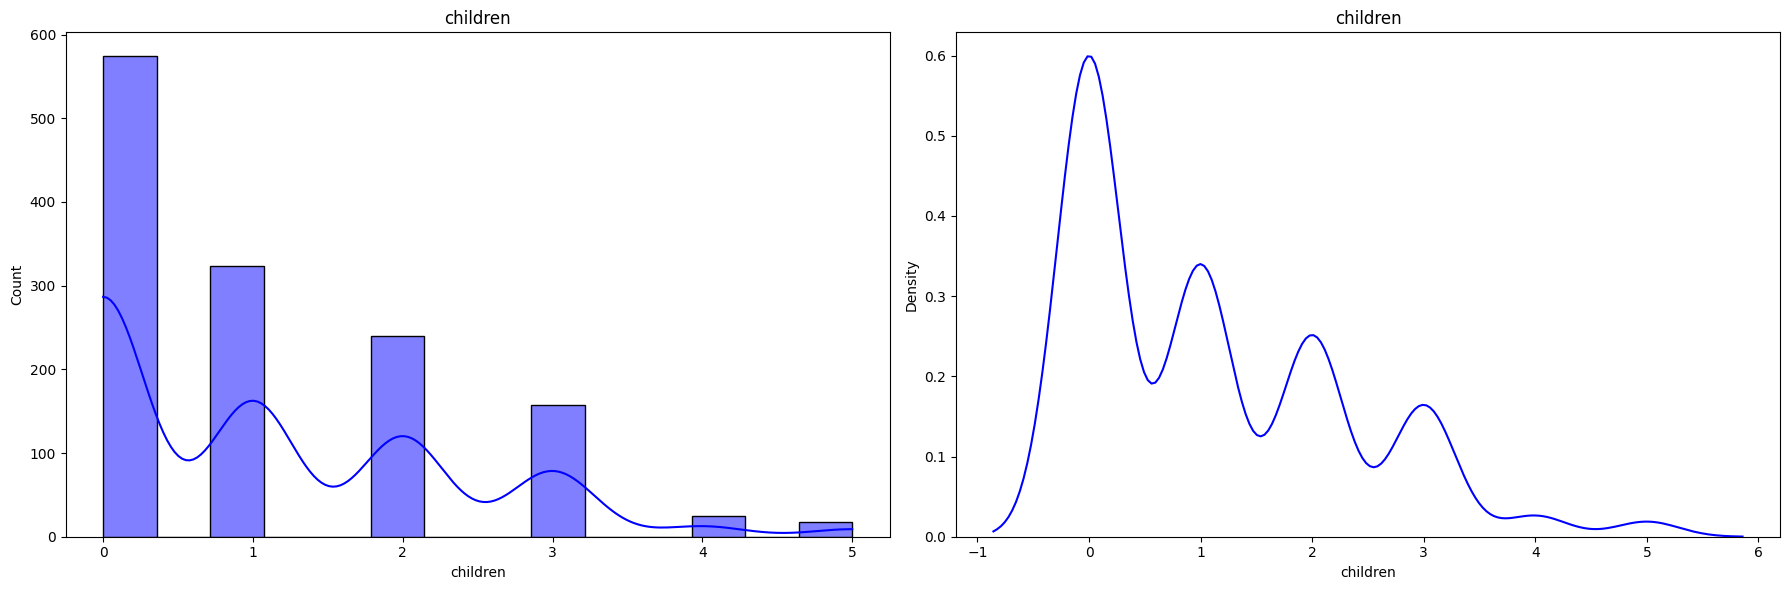


charges (skewness: 1.52)


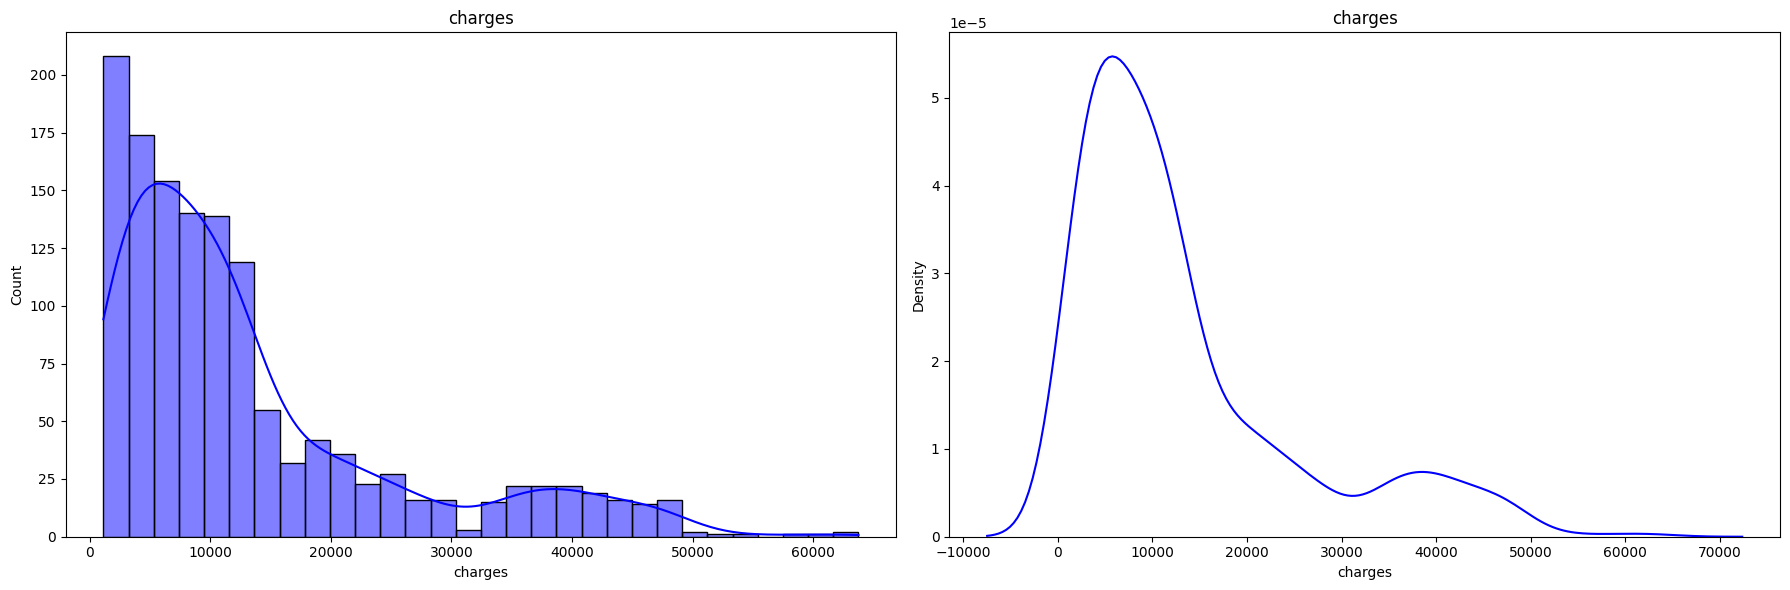

In [ ]:
def determine_skewed_features(df, features, skew_threshold=0.5):
  skewness = df[features].skew()
  print("Skewness values:\n", skewness)

  for feature in features:
    if abs(skewness[feature]) > skew_threshold:
      print(f"\n{feature} (skewness: {skewness[feature]:.2f})")

      fig, axes = plt.subplots(1, 2, figsize=(18, 6))
      sns.histplot(df[feature], kde=True, color='blue', ax=axes[0])
      axes[0].set_title(f'{feature}')
      sns.kdeplot(df[feature], color='blue', ax=axes[1])
      axes[1].set_title(f'{feature}')
      plt.tight_layout()
      plt.show()

determine_skewed_features(df, numerical_features, skew_threshold=0.5)

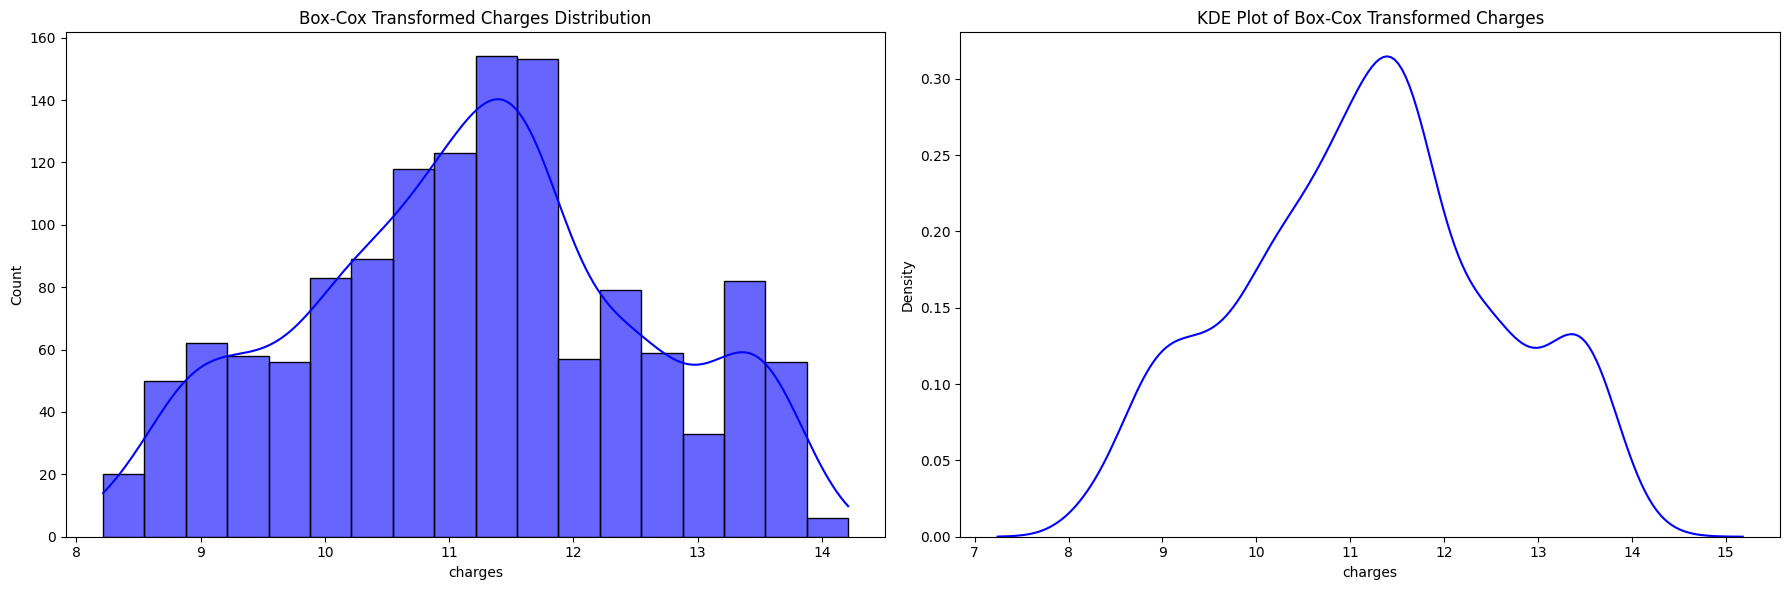

Skewness after Box-Cox transformation: -0.0087


In [ ]:
df['charges'], _ = boxcox(df['charges'] + 1)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(df['charges'], kde=True, ax=ax[0], color='blue', edgecolor='black', alpha=0.6)
ax[0].set_title('Box-Cox Transformed Charges Distribution')

sns.kdeplot(df['charges'], ax=ax[1], color='blue')
ax[1].set_title('KDE Plot of Box-Cox Transformed Charges')

plt.tight_layout()
plt.show()

skewness_transformed = df['charges'].skew()
print(f'Skewness after Box-Cox transformation: {skewness_transformed:.4f}')

In [ ]:
def correlation_analysis_for_selection(df, target_variable, threshold=0.1, plot=True):

    numerical_df = df.select_dtypes(include=['float64', 'int64'])
    pearson_corr_with_target = numerical_df.corr(method='pearson')[target_variable].drop(target_variable)
    spearman_corr_with_target = numerical_df.corr(method='spearman')[target_variable].drop(target_variable)

    pearson_corr_matrix = numerical_df.corr(method='pearson')
    spearman_corr_matrix = numerical_df.corr(method='spearman')

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.heatmap(pearson_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[0])
    axes[0].set_title('Pearson Correlation Matrix')
    sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1])
    axes[1].set_title('Spearman Correlation Matrix')
    plt.tight_layout()
    plt.show()

    # Select features based on Pearson and Spearman correlations
    selected_pearson_features = pearson_corr_with_target[pearson_corr_with_target.abs() > threshold].index.tolist()
    selected_spearman_features = spearman_corr_with_target[spearman_corr_with_target.abs() > threshold].index.tolist()

    # Combine both feature selections
    combined_selected_features = sorted(list(set(selected_pearson_features) | set(selected_spearman_features)))
    print("Selected features based on Pearson correlation:", selected_pearson_features)
    print("Selected features based on Spearman correlation:", selected_spearman_features)
    print("Combined selected features (from Pearson and Spearman):", combined_selected_features)
    return combined_selected_features

In [ ]:
def point_biserial_for_selection(df, target_variable, corr_threshold=0.1, p_value_threshold=0.05):
    print("Point-Biserial correlation")
    print("-" * 50)

    binary_features = [col for col in df.columns if df[col].nunique() == 2 and col != target_variable]
    selected_features = []

    le = LabelEncoder()

    for feature in binary_features:
        binary_encoded = le.fit_transform(df[feature])
        correlation, p_value = pointbiserialr(binary_encoded, df[target_variable])
        print(f"{feature}: Correlation={correlation:.4f}, P-value={p_value:.4f}")

        if abs(correlation) > corr_threshold and p_value < p_value_threshold:
            selected_features.append(feature)

    print("\nSelected binary features based on Point-Biserial correlation:", selected_features)
    return selected_features

In [ ]:
def anova_for_selection(df, categorical_features, target_variable, p_value_threshold=0.05):
    selected_features = []

    for categorical_feature in categorical_features:
        print(f"\nANOVA correlation between '{categorical_feature}' and '{target_variable}'")
        print("-" * 50)

        data = df[[categorical_feature, target_variable]].dropna()
        categories = data[categorical_feature].unique()

        if len(categories) < 2:
            print(f"Feature '{categorical_feature}' has less than two categories, skipping.")
            continue

        groups = [data[data[categorical_feature] == category][target_variable] for category in categories]

        # ANOVA test
        try:
            anova_result = f_oneway(*groups)
        except ValueError as e:
            continue

        print(f"ANOVA F-Statistic: {anova_result.statistic:.4f}, P-Value: {anova_result.pvalue:.4e}")

        # Check significance based on p-value
        if anova_result.pvalue < p_value_threshold:
            print(f"Feature '{categorical_feature}' is significant (p-value={anova_result.pvalue:.4e})")
            selected_features.append(categorical_feature)
        else:
            print(f"Feature '{categorical_feature}' is not significant (p-value={anova_result.pvalue:.4e})")

    print("\nSelected categorical features based on ANOVA:", selected_features)
    return selected_features

In [ ]:
def chi_square_for_selection(df, categorical_columns, p_value_threshold=0.05):
    selected_features = set()

    for i in range(len(categorical_columns)):
        for j in range(i + 1, len(categorical_columns)):
            if df[categorical_columns[i]].nunique() < 2 or df[categorical_columns[j]].nunique() < 2:
                continue

            contingency_table = pd.crosstab(df[categorical_columns[i]], df[categorical_columns[j]])
            chi2, p, dof, ex = chi2_contingency(contingency_table)

            print(f"\nChi-Square Test between '{categorical_columns[i]}' and '{categorical_columns[j]}'")
            print(f"Chi2 Statistic: {chi2:.4f}, P-Value: {p:.4e}, Degrees of Freedom: {dof}")
            print("-" * 50)

            if p < p_value_threshold:
                print(f"'{categorical_columns[i]}' and '{categorical_columns[j]}' are dependent (p-value={p:.4e})")
                selected_features.add(categorical_columns[i])
                selected_features.add(categorical_columns[j])

    return list(selected_features)

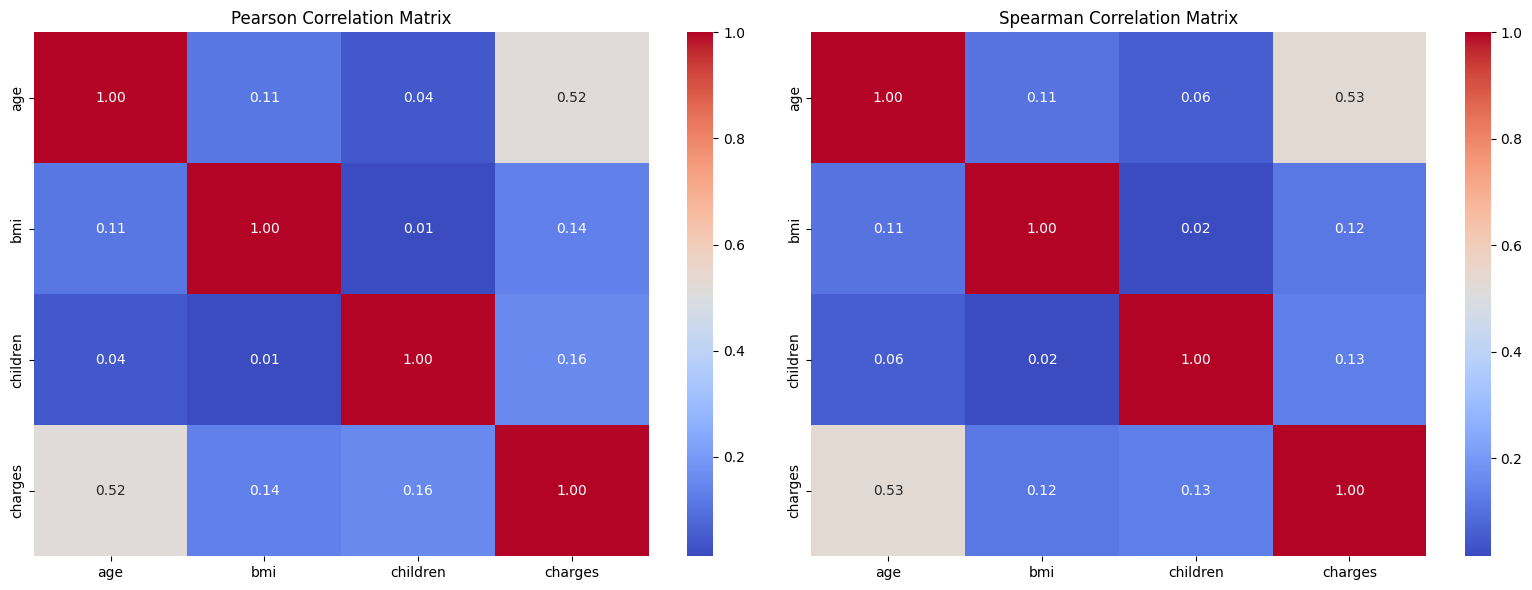

Selected features based on Pearson correlation: ['age', 'bmi', 'children']
Selected features based on Spearman correlation: ['age', 'bmi', 'children']
Combined selected features (from Pearson and Spearman): ['age', 'bmi', 'children']

Selected numerical features: ['age', 'bmi', 'children']
Point-Biserial correlation
--------------------------------------------------
sex: Correlation=0.0087, P-value=0.7506
smoker: Correlation=0.6757, P-value=0.0000

Selected binary features based on Point-Biserial correlation: ['smoker']

Selected binary features: ['smoker']

ANOVA correlation between 'region' and 'charges'
--------------------------------------------------
ANOVA F-Statistic: 1.4185, P-Value: 2.3567e-01
Feature 'region' is not significant (p-value=2.3567e-01)

Selected categorical features based on ANOVA: []

Selected categorical feature(s) from ANOVA: []

Chi-Square Test between 'sex' and 'region'
Chi2 Statistic: 0.4351, P-Value: 9.3289e-01, Degrees of Freedom: 3
----------------------

In [ ]:
# Get the lists of categorical and numerical features
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=['number']).columns.tolist()

# Correlation analysis for numerical features
selected_numerical_features = correlation_analysis_for_selection(df, 'charges')
print("\nSelected numerical features:", selected_numerical_features)

# Point-Biserial correlation for binary features
selected_binary_features = point_biserial_for_selection(df, 'charges')
print("\nSelected binary features:", selected_binary_features)

# Exclude binary features from the list of categorical features (they are already handled)
categorical_features = [feature for feature in categorical_features if feature not in selected_binary_features]

# ANOVA for categorical feature 'region'
selected_categorical_features_anova = anova_for_selection(df, ['region'], 'charges')
print("\nSelected categorical feature(s) from ANOVA:", selected_categorical_features_anova)

# Chi-Square test for remaining categorical features
selected_categorical_features_chi = chi_square_for_selection(df, categorical_features)
print("\nSelected categorical features based on Chi-Square Test:", selected_categorical_features_chi)

# Combine all selected features for final feature list
selected_features = set(selected_numerical_features + selected_binary_features + selected_categorical_features_chi)

# Add the ANOVA selected features if any
if selected_categorical_features_anova:
    selected_features.update(selected_categorical_features_anova)

# Output final list of selected features
print("\nFinal filter method selected features:", list(selected_features))

Training Linear Regression...
Linear Regression:
  Train RMSE: 0.6684575793882448
  Train R²: 0.7557094552750219
  Test RMSE: 0.6308841676179573
  Test R²: 0.7991426362066956
------------------------------
Training Lasso Regression...
Lasso Regression:
  Train RMSE: 0.7174697595230248
  Train R²: 0.7185727443753398
  Test RMSE: 0.6903595186042701
  Test R²: 0.7594866787819906
------------------------------
Training Ridge Regression...
Ridge Regression:
  Train RMSE: 0.6684577958040314
  Train R²: 0.7557092970949351
  Test RMSE: 0.6308864027891273
  Test R²: 0.7991412129616463
------------------------------
Training Decision Tree...
Decision Tree:
  Train RMSE: 0.26937626745055365
  Train R²: 0.9603285918798246
  Test RMSE: 0.7822011912220365
  Test R²: 0.6912368613238882
------------------------------
Training Random Forest...
Random Forest:
  Train RMSE: 0.3036754633737877
  Train R²: 0.9495828421494086
  Test RMSE: 0.5670209904912412
  Test R²: 0.8377492273600181
--------------------

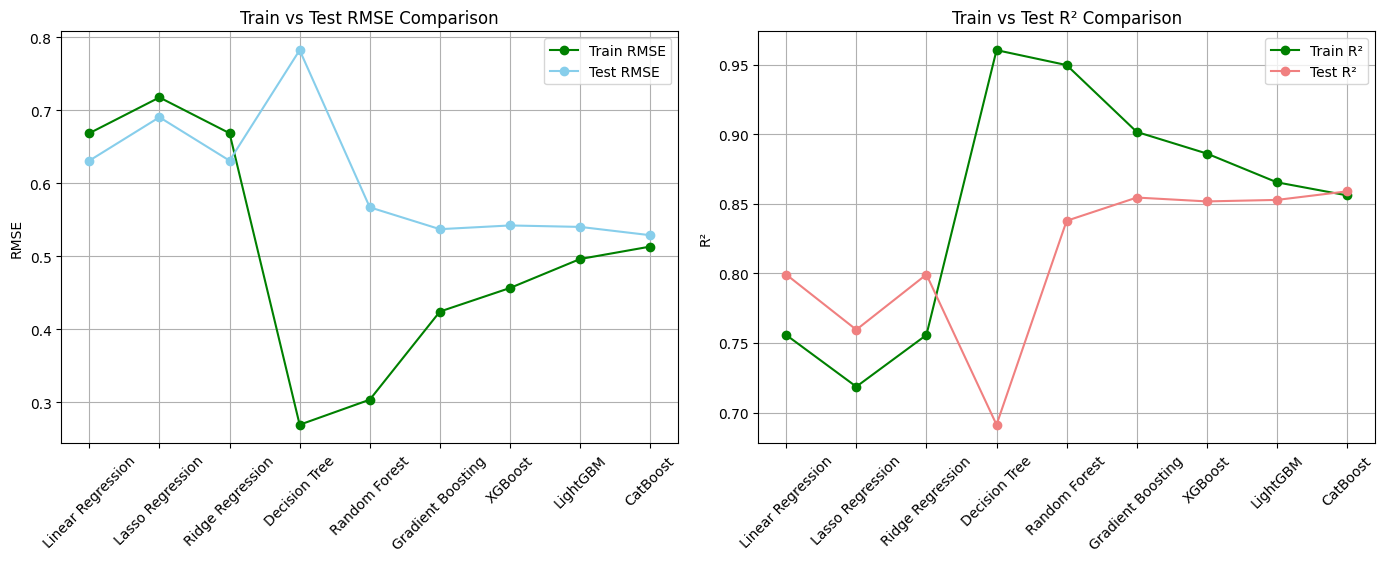

In [ ]:
X = df[list(selected_features)]
y = df['charges']

label_encoder = LabelEncoder()
smoker_encoder = FunctionTransformer(lambda col: label_encoder.fit_transform(col).reshape(-1, 1), validate=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('smoker', smoker_encoder, ['smoker']),  # Apply LabelEncoder to 'smoker'
    ],
    remainder='passthrough'
)

# Apply the preprocessor to the feature set
X_encoded = preprocessor.fit_transform(X)

# Other categorical features (like 'region'), can be enncoded using OneHotEncoder
# (Skipping this step since 'region' is not included in selected features)

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1, random_state=42),
    'Ridge Regression': Ridge(alpha=0.1, random_state=42),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, verbosity=0, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, verbose=-1, random_state=42),
    'CatBoost': CatBoostRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, verbose=0, random_state=42)
}

model_performance = {
    'Model': [],
    'Train RMSE': [],
    'Train R²': [],
    'Test RMSE': [],
    'Test R²': []
}

for name, model in models.items():
    print(f"Training {name}...")

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_r2 = r2_score(y_test, y_test_pred)

    model_performance['Model'].append(name)
    model_performance['Train RMSE'].append(train_rmse)
    model_performance['Train R²'].append(train_r2)
    model_performance['Test RMSE'].append(test_rmse)
    model_performance['Test R²'].append(test_r2)

    print(f"{name}:")
    print(f"  Train RMSE: {train_rmse}")
    print(f"  Train R²: {train_r2}")
    print(f"  Test RMSE: {test_rmse}")
    print(f"  Test R²: {test_r2}")
    print("-" * 30)

performance_df = pd.DataFrame(model_performance)
print("\nPerformance Comparison Across Models:")
print(performance_df)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.plot(performance_df['Model'], performance_df['Train RMSE'], marker='o', linestyle='-', color='green', label='Train RMSE')
plt.plot(performance_df['Model'], performance_df['Test RMSE'], marker='o', linestyle='-', color='skyblue', label='Test RMSE')
plt.xticks(rotation=45)
plt.ylabel('RMSE')
plt.title('Train vs Test RMSE Comparison')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(performance_df['Model'], performance_df['Train R²'], marker='o', linestyle='-', color='green', label='Train R²')
plt.plot(performance_df['Model'], performance_df['Test R²'], marker='o', linestyle='-', color='lightcoral', label='Test R²')
plt.xticks(rotation=45)
plt.ylabel('R²')
plt.title('Train vs Test R² Comparison')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define hyperparameter grid for CatBoost
catboost_params = {
    'iterations': [100, 200, 300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128, 256]
}

# Define hyperparameter grid for LightGBM
lightgbm_params = {
    'n_estimators': [100, 200, 300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'num_leaves': [20, 31, 40, 50],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

catboost = CatBoostRegressor(verbose=0, random_state=42)
lightgbm = LGBMRegressor(random_state=42)

# Perform Randomized Search for CatBoost
random_search_catboost = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=catboost_params,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Perform Randomized Search for LightGBM
random_search_lightgbm = RandomizedSearchCV(
    estimator=lightgbm,
    param_distributions=lightgbm_params,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Tuning CatBoost...")
random_search_catboost.fit(X_train, y_train)
print("Tuning LightGBM...")
random_search_lightgbm.fit(X_train, y_train)

# Get the best parameters for each model
best_params_catboost = random_search_catboost.best_params_
best_params_lightgbm = random_search_lightgbm.best_params_

print("Best CatBoost parameters: ", best_params_catboost)
print("Best LightGBM parameters: ", best_params_lightgbm)

# Evaluate the performance of both models
print("\nEvaluating the best CatBoost model:")
best_catboost = random_search_catboost.best_estimator_
y_pred_catboost = best_catboost.predict(X_test)
catboost_rmse = mean_squared_error(y_test, y_pred_catboost, squared=False)
print(f"CatBoost RMSE: {catboost_rmse:.4f}")

print("\nEvaluating the best LightGBM model:")
best_lightgbm = random_search_lightgbm.best_estimator_
y_pred_lightgbm = best_lightgbm.predict(X_test)
lightgbm_rmse = mean_squared_error(y_test, y_pred_lightgbm, squared=False)
print(f"LightGBM RMSE: {lightgbm_rmse:.4f}")

Tuning CatBoost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuning LightGBM...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best CatBoost parameters:  {'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 4, 'border_count': 128}
Best LightGBM parameters:  {'subsample': 0.8, 'num_leaves': 20, 'n_estimators': 300, 'min_child_samples': 30, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 1.0}

Evaluating the best CatBoost model:
CatBoost RMSE: 0.5257

Evaluating the best LightGBM model:
LightGBM RMSE: 0.5375


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# Evaluate CatBoost on Additional Metrics
print("\nEvaluating the best CatBoost model on additional metrics:")
y_pred_catboost = best_catboost.predict(X_test)

# Metrics for CatBoost
catboost_rmse = mean_squared_error(y_test, y_pred_catboost, squared=False)
catboost_mae = mean_absolute_error(y_test, y_pred_catboost)
catboost_r2 = r2_score(y_test, y_pred_catboost)

print(f"CatBoost RMSE: {catboost_rmse:.4f}")
print(f"CatBoost MAE: {catboost_mae:.4f}")
print(f"CatBoost R²: {catboost_r2:.4f}")

# Evaluate LightGBM on Additional Metrics
print("\nEvaluating the best LightGBM model on additional metrics:")
y_pred_lightgbm = best_lightgbm.predict(X_test)

# Metrics for LightGBM
lightgbm_rmse = mean_squared_error(y_test, y_pred_lightgbm, squared=False)
lightgbm_mae = mean_absolute_error(y_test, y_pred_lightgbm)
lightgbm_r2 = r2_score(y_test, y_pred_lightgbm)

print(f"LightGBM RMSE: {lightgbm_rmse:.4f}")
print(f"LightGBM MAE: {lightgbm_mae:.4f}")
print(f"LightGBM R²: {lightgbm_r2:.4f}")


Evaluating the best CatBoost model on additional metrics:
CatBoost RMSE: 0.5257
CatBoost MAE: 0.2892
CatBoost R²: 0.8606

Evaluating the best LightGBM model on additional metrics:
LightGBM RMSE: 0.5375
LightGBM MAE: 0.3051
LightGBM R²: 0.8542


In [ ]:
catboost_fine_params = {
    'iterations': [450, 500, 550],  # Narrow down around 500
    'learning_rate': [0.005, 0.01, 0.02],  # Fine-tune around 0.01
    'depth': [3, 4, 5],  # Fine-tune around depth 4
    'l2_leaf_reg': [1, 2, 3],  # Regularization fine-tuning
    'border_count': [120, 128, 136]  # Narrow down around 128
}

# Initialize CatBoost Regressor with earlier found parameters
catboost = CatBoostRegressor(verbose=0, random_state=42)

# Perform a finer Randomized Search
fine_tune_search_catboost = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=catboost_fine_params,
    n_iter=10,  # Try 10 different combinations
    scoring='neg_mean_squared_error',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the fine-tuned model
fine_tune_search_catboost.fit(X_train, y_train)

# Get the best parameters from fine-tuning
best_fine_params_catboost = fine_tune_search_catboost.best_params_

print("Best fine-tuned CatBoost parameters: ", best_fine_params_catboost)

# Evaluate the fine-tuned model
best_fine_catboost = fine_tune_search_catboost.best_estimator_
y_pred_fine_catboost = best_fine_catboost.predict(X_test)

# Calculate evaluation metrics
fine_catboost_rmse = mean_squared_error(y_test, y_pred_fine_catboost, squared=False)
fine_catboost_mae = mean_absolute_error(y_test, y_pred_fine_catboost)
fine_catboost_r2 = r2_score(y_test, y_pred_fine_catboost)

print("\nEvaluating the fine-tuned CatBoost model:")
print(f"Fine-Tuned CatBoost RMSE: {fine_catboost_rmse:.4f}")
print(f"Fine-Tuned CatBoost MAE: {fine_catboost_mae:.4f}")
print(f"Fine-Tuned CatBoost R²: {fine_catboost_r2:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best fine-tuned CatBoost parameters:  {'learning_rate': 0.01, 'l2_leaf_reg': 2, 'iterations': 550, 'depth': 5, 'border_count': 136}

Evaluating the fine-tuned CatBoost model:
Fine-Tuned CatBoost RMSE: 0.5241
Fine-Tuned CatBoost MAE: 0.2857
Fine-Tuned CatBoost R²: 0.8614


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Define categorical feature indices (here, 'smoker' is categorical)
cat_features = ['smoker']

# Initialize the best fine-tuned CatBoost model with the best parameters
catboost_cv_model = CatBoostRegressor(
    iterations=500,  # Best value from tuning
    learning_rate=0.01,  # Best value from tuning
    depth=4,  # Best value from tuning
    l2_leaf_reg=1,  # Best value from tuning
    border_count=128,  # Best value from tuning
    cat_features=cat_features,  # Specify categorical features
    verbose=0,  # Disable output
    random_state=42  # Ensure reproducibility
)

# Perform 5-fold cross-validation on the entire dataset
# Scoring will use 'neg_mean_squared_error' to calculate RMSE later
cv_scores = cross_val_score(catboost_cv_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Convert negative MSE to RMSE
rmse_scores = np.sqrt(-cv_scores)

# Print RMSE for each fold
print(f"RMSE for each fold: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean():.4f}")
print(f"Standard Deviation of RMSE: {rmse_scores.std():.4f}")

RMSE for each fold: [0.49390949 0.69322414 0.44355973 0.55794795 0.57744983]
Mean RMSE: 0.5532
Standard Deviation of RMSE: 0.0846



Fold 1 Analysis:
Train set 'charges' mean: 11.21, std: 1.35
Test set 'charges' mean: 11.11, std: 1.41


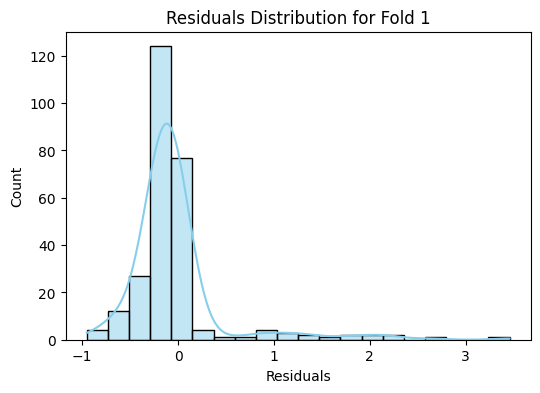

Outliers detected in fold 1: 14 samples with high residuals.

Fold 2 Analysis:
Train set 'charges' mean: 11.18, std: 1.37
Test set 'charges' mean: 11.24, std: 1.35


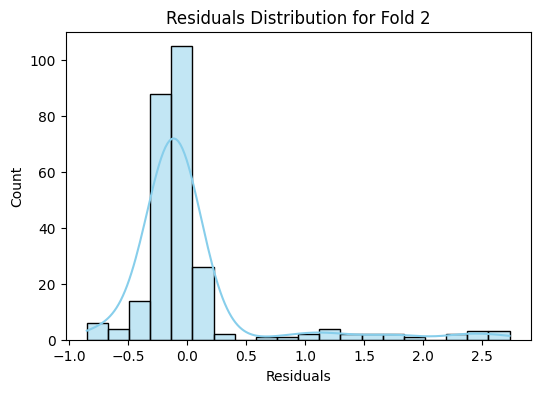

Outliers detected in fold 2: 17 samples with high residuals.

Fold 3 Analysis:
Train set 'charges' mean: 11.17, std: 1.36
Test set 'charges' mean: 11.28, std: 1.36


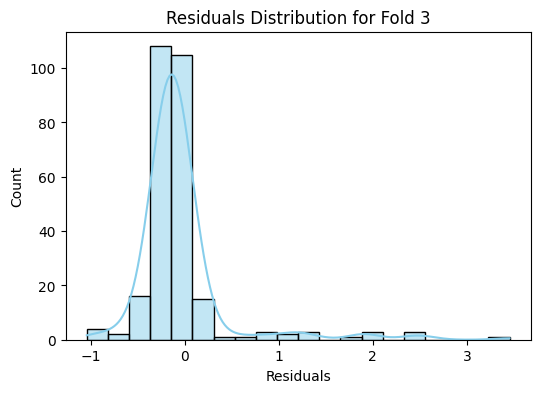

Outliers detected in fold 3: 14 samples with high residuals.

Fold 4 Analysis:
Train set 'charges' mean: 11.19, std: 1.38
Test set 'charges' mean: 11.20, std: 1.30


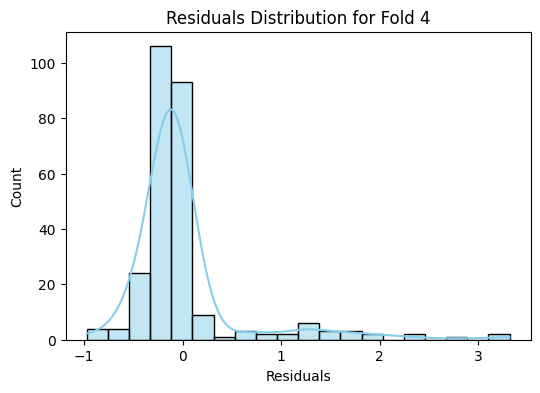

Outliers detected in fold 4: 18 samples with high residuals.

Fold 5 Analysis:
Train set 'charges' mean: 11.20, std: 1.36
Test set 'charges' mean: 11.14, std: 1.40


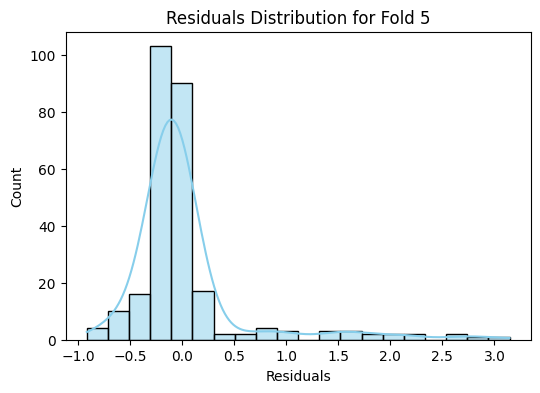

Outliers detected in fold 5: 16 samples with high residuals.

Fold Data Summary:
   Fold  Train Charges Mean  Train Charges Std  Test Charges Mean  \
0     1           11.212411           1.353080          11.105955   
1     2           11.179367           1.369661          11.237883   
2     3           11.169151           1.364720          11.278673   
3     4           11.190002           1.380722          11.195443   
4     5           11.204497           1.356142          11.137302   

   Test Charges Std  
0          1.410320  
1          1.347069  
2          1.364483  
3          1.301819  
4          1.400617  


In [ ]:
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize arrays to store results
fold_data_stats = []

# Perform KFold splits and analysis
fold_index = 1
for train_index, test_index in kf.split(X, y):
    # Get train and test data for this fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Analyze the distribution of 'charges' in this fold
    charges_train = y_train_fold
    charges_test = y_test_fold

    print(f"\nFold {fold_index} Analysis:")
    print(f"Train set 'charges' mean: {charges_train.mean():.2f}, std: {charges_train.std():.2f}")
    print(f"Test set 'charges' mean: {charges_test.mean():.2f}, std: {charges_test.std():.2f}")

    # Store the statistics for each fold
    fold_data_stats.append({
        'Fold': fold_index,
        'Train Charges Mean': charges_train.mean(),
        'Train Charges Std': charges_train.std(),
        'Test Charges Mean': charges_test.mean(),
        'Test Charges Std': charges_test.std()
    })

    # Fit model on this fold's training data
    catboost_cv_model.fit(X_train_fold, y_train_fold)

    # Predict and calculate residuals (errors) on the test data
    y_pred_fold = catboost_cv_model.predict(X_test_fold)
    residuals = y_test_fold - y_pred_fold

    # Plot the distribution of residuals
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, color='skyblue', bins=20)
    plt.title(f'Residuals Distribution for Fold {fold_index}')
    plt.xlabel('Residuals')
    plt.show()

    # Check for outliers in residuals
    high_error_indices = np.where(np.abs(residuals) > 2 * residuals.std())[0]
    if len(high_error_indices) > 0:
        print(f"Outliers detected in fold {fold_index}: {len(high_error_indices)} samples with high residuals.")
    else:
        print(f"No significant outliers detected in fold {fold_index}.")

    fold_index += 1

# Convert fold data statistics into a DataFrame for easy viewing
fold_stats_df = pd.DataFrame(fold_data_stats)
print("\nFold Data Summary:")
print(fold_stats_df)

In [ ]:
fold_index = 1
for train_index, test_index in kf.split(X, y):
    if fold_index == 5:
        # Get the train and test data for fold 5
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Fit the CatBoost model on the training data of fold 5
        catboost_cv_model.fit(X_train_fold, y_train_fold)

        # Make predictions and calculate residuals (errors) on the test data
        y_pred_fold = catboost_cv_model.predict(X_test_fold)
        residuals = y_test_fold - y_pred_fold

        # Identify outliers in fold 5 (samples with residuals > 2 * residuals.std())
        outlier_indices = np.where(np.abs(residuals) > 2 * residuals.std())[0]
        outliers = X_test_fold.iloc[outlier_indices]
        outlier_residuals = residuals.iloc[outlier_indices]

        # Display the outliers and their residuals
        print(f"Outliers in Fold 5 (16 samples):")
        print(outliers)
        print("\nResiduals for outliers in Fold 5:")
        print(outlier_residuals)

    fold_index += 1

Outliers in Fold 5 (16 samples):
         bmi smoker  children  age
143   29.735     no         2   29
219   23.210     no         0   24
387   25.365     no         2   50
397   31.020     no         0   21
520   27.360     no         0   50
658   35.910     no         1   48
957   26.790     no         1   24
959   36.670     no         1   48
1012  33.330     no         4   61
1019  32.680     no         2   21
1104  29.800     no         0   37
1123  32.395     no         1   27
1162  38.830     no         1   30
1215  39.140     no         0   18
1315  28.310     no         1   18
1318  39.710     no         4   35

Residuals for outliers in Fold 5:
143     1.744571
219     3.144654
387     1.547175
397     2.874260
520     1.424662
658     1.553518
957     1.787288
959     1.672551
1012    1.388520
1019    2.722250
1104    1.928024
1123    2.215833
1162    2.137857
1215    2.616467
1315    2.100399
1318    1.481307
Name: charges, dtype: float64
